# LeNet

Among the first ground breaking result for CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb

In the 90s, optical character recognition was a hot topic  
Especially for banks who had to had to process millions of bank check a year (at that time, credit cards were not as popular as today)

In 1998, Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner proposed a CNN architecture and a gradient-based approach to train it on handwritten character recognition (**MNIST** dataset)

<center>
    <img src='images/mnist.png' width="65%" style="margin-left:auto; margin-right:auto"/>
    <p style="font-size:14px;">Source: <a href='http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf'>LeCun's MNIST paper</a></p>
</center>

In [2]:
class LeCunRevisited(nn.Module):
    
    def __init__(self):
        super(LeCunRevisited, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.max_pool = nn.MaxPool2d(kernel_size=2) # original uses AvgPool, kernel size 2 divide the ouput by 4
        
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x)) # original uses Sigmoid
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
net = LeCunRevisited()
net(torch.randn(2, 1, 32, 32))

tensor([[ 0.0525,  0.0065, -0.1625, -0.0853, -0.0129,  0.0669,  0.0608, -0.0669,
         -0.1539, -0.0058],
        [ 0.0588, -0.0021, -0.1439, -0.1186, -0.0249,  0.0575,  0.0483, -0.0661,
         -0.1656,  0.0059]], grad_fn=<AddmmBackward0>)

Let's now solve MNIST using *LeCun* architecture

First, let's download the data

In [4]:
import torchvision
from torchvision import transforms
mnist_train = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())


In [5]:
print(f'Number of training examples: {len(mnist_train)}')
print(f'Number of test examples: {len(mnist_test)}')
print(f'Image size: {mnist_train[0][0].shape}')

Number of training examples: 60000
Number of test examples: 10000
Image size: torch.Size([1, 28, 28])


Notice that the MNIST data from *torchvision* are 28x28 compare to the 32x32 from *LeCun*'s paper

It's always a good idea to look at our data before doing anything

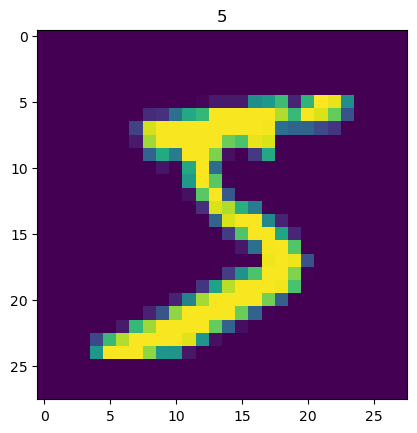

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.show()

show(mnist_train[0][0], mnist_train[0][1])

Now let's create the dataloaders so we can have batch to train/test our network on

In [7]:
mnist_dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

We have to define a *LeCun* model that is compatible with the 28*28 input image

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LeCunRevisited(nn.Module):

    def __init__(self):
        super(LeCunRevisited, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.max_pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = LeCunRevisited()
model.to(device)

LeCunRevisited(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Our traditional training loop

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
wandb.init(project='LeCunExample')

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    i = 0
    for i, data in enumerate(mnist_dataloader_train):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            running_loss += loss.cpu().item()
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
            running_acc += (predicted == labels).float().mean().item()
    wandb.log({'loss': running_loss / (i + 1),
                'acc': running_acc / (i + 1),
                'epoch': epoch + 1})


wandb: Currently logged in as: ingambe (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


We now need to check the accuracy on the test dataset

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for data in mnist_dataloader_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the {total} test images dataset: {100 * correct / total}%')

Accuracy of the network on the 10000 test images dataset: 98.7%


Great! Now let's save our awesome model to the disk

In [14]:
torch.save(model.state_dict(), 'mnist.pth')
wandb.save('mnist.pth')

['/Users/ingambe/PycharmProjects/PracticumAAUDeepLearning/4-CNN/Slides/wandb/run-20221109_205443-2ccf46w8/files/mnist.pth']